# MLP 

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

import requests 


In [46]:
# url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
url = "https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt" #English dictionary
res = requests.get(url)
words = (res.text).splitlines()
print(len(words),max(len(w) for w in words),min(len(w) for w in words))

370105 31 1


In [47]:
chars = sorted(list(set((''.join(words)))))  #get unique characters 
stoi = {s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."] = 0 
itos = {i:s for s, i in stoi.items()}        # map int to char

In [63]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([3091093, 8]) torch.Size([3091093])
torch.Size([387073, 8]) torch.Size([387073])
torch.Size([386646, 8]) torch.Size([386646])


In [64]:
Ytr[3]

tensor(24)

In [65]:
n_embd = 10

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn( (27, n_embd),    generator=g)
W1 = torch.randn((n_embd * block_size, 200),  generator=g)*0.1
b1 = torch.randn(200,        generator=g)*0.1
W2 = torch.randn((200, 27),  generator=g)*0.1
b2 = torch.randn(27,         generator=g)*0.1
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

lossi = []
stepi = []

In [74]:
max_steps = 1
batch_size = 1

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  print(emb.shape)
  h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
  print(h.shape,emb.view(-1, n_embd * block_size).shape, W1.shape, b1.shape)
  logits = h @ W2 + b2 # (32, 27)
  print(logits.shape, h.shape, W2.shape, b2.shape)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 10000 else 0.01 # learning rate decay  
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  
  stepi.append(i)
  lossi.append(loss.log10().item())

  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
    


torch.Size([1, 8, 10])
torch.Size([1, 200]) torch.Size([1, 80]) torch.Size([80, 200]) torch.Size([200])
torch.Size([1, 27]) torch.Size([1, 200]) torch.Size([200, 27]) torch.Size([27])
      0/      1: 3.7580


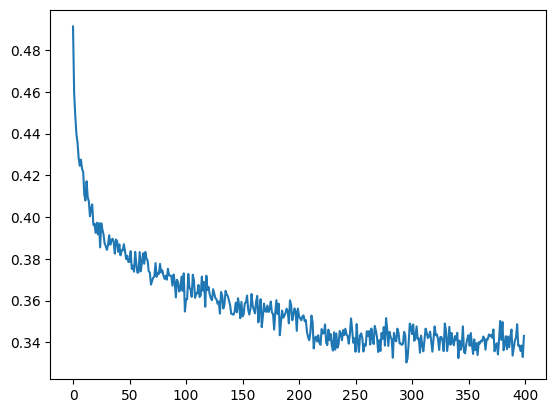

In [68]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [69]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]

    emb=C[x]
    emcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(emcat@ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('val')
# split_loss('test')

train 2.193101644515991
val 2.195143222808838


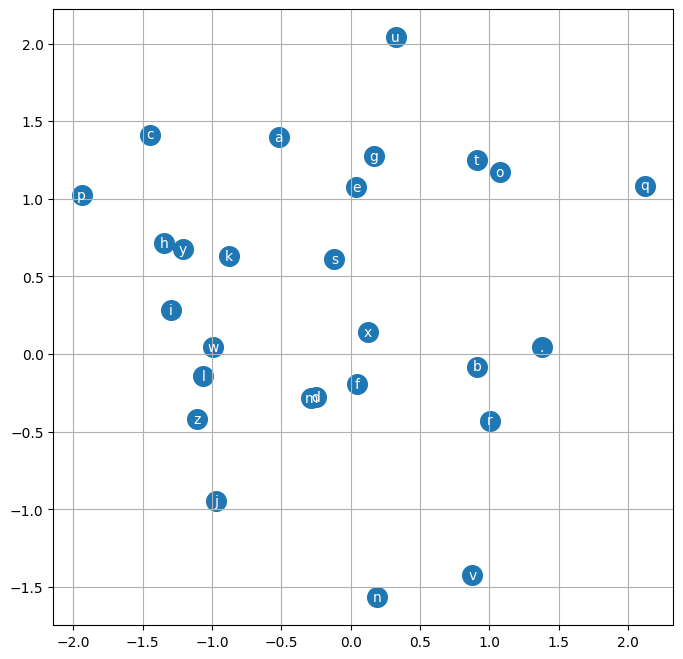

In [70]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [71]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 89)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

hoilimy.
tiklearf.
jateflent.
athanalum.
chyphained.
zemis.
vencasting.
crudgresic.
undlelogs.
reosecise.
sterbints.
contionispeal.
preeasia.
igmanotives.
mecnools.
craduli.
beinoration.
eabrifowrapha.
gegrus.
dilllest.
